In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
from matplotlib import colors as cl
import matplotlib.lines as lines
import seaborn as sns
import scipy.stats as sts
import sys
import os
from matplotlib import cm

import birdepy as bd

In [2]:
## read in data

# get relative path to spreadsheet 
# filter out uneeded columns


hospital_data = pd.read_csv("COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv")

C:\Users\564207\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (28,29,30,48,49,50,95,102,103,104,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#filter data
cols_keep = ["hospital_name","collection_week","city","state","all_adult_hospital_inpatient_beds_7_day_avg",
            "inpatient_beds_used_7_day_avg","total_icu_beds_7_day_avg","icu_beds_used_7_day_avg",
             "total_adult_patients_hospitalized_confirmed_covid_7_day_sum",
            "previous_day_admission_adult_covid_confirmed_7_day_coverage"]
hospital_data = hospital_data.filter(cols_keep)
hospital_data = hospital_data[hospital_data.notnull().all(1)]

hospital_data = hospital_data.convert_dtypes()

hospital_data.all_adult_hospital_inpatient_beds_7_day_avg = hospital_data.all_adult_hospital_inpatient_beds_7_day_avg.apply(lambda x: x.replace(",",""))
hospital_data.inpatient_beds_used_7_day_avg = hospital_data.inpatient_beds_used_7_day_avg.apply(lambda x: x.replace(",",""))
hospital_data.total_icu_beds_7_day_avg = hospital_data.total_icu_beds_7_day_avg.apply(lambda x: x.replace(",",""))
hospital_data.icu_beds_used_7_day_avg = hospital_data.icu_beds_used_7_day_avg.apply(lambda x: x.replace(",",""))
hospital_data.total_adult_patients_hospitalized_confirmed_covid_7_day_sum = hospital_data.total_adult_patients_hospitalized_confirmed_covid_7_day_sum.apply(lambda x: x.replace(",",""))

hospital_data = hospital_data.astype({"all_adult_hospital_inpatient_beds_7_day_avg":'float64',
            "inpatient_beds_used_7_day_avg":'float64',"total_icu_beds_7_day_avg":'float64',"icu_beds_used_7_day_avg":'float64',
            "previous_day_admission_adult_covid_confirmed_7_day_coverage":'float64',"total_adult_patients_hospitalized_confirmed_covid_7_day_sum":'float64'})

hospital_data = hospital_data[(hospital_data.total_icu_beds_7_day_avg >0) & (hospital_data.all_adult_hospital_inpatient_beds_7_day_avg > 0) & 
                              (hospital_data.total_adult_patients_hospitalized_confirmed_covid_7_day_sum >= 0)]
hospital_data["percent_beds_used"] = hospital_data.inpatient_beds_used_7_day_avg / hospital_data.all_adult_hospital_inpatient_beds_7_day_avg
hospital_data["percent_icu_used"] = hospital_data.icu_beds_used_7_day_avg / hospital_data.total_icu_beds_7_day_avg
hospital_data["total_beds_avail"] = hospital_data.all_adult_hospital_inpatient_beds_7_day_avg - hospital_data.inpatient_beds_used_7_day_avg
hospital_data["icu_beds_avail"] = hospital_data.total_icu_beds_7_day_avg - hospital_data.icu_beds_used_7_day_avg


hospital_data = hospital_data[(hospital_data.percent_beds_used >= 0) & (hospital_data.percent_icu_used >= 0)]

hospital_data.collection_week = pd.to_datetime(hospital_data.collection_week)
hospital_data = hospital_data.sort_values(["collection_week","hospital_name","city","state"])
hospital_data.reset_index()

hospital_data.head()

,hospital_name,collection_week,city,state,all_adult_hospital_inpatient_beds_7_day_avg,inpatient_beds_used_7_day_avg,total_icu_beds_7_day_avg,icu_beds_used_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,previous_day_admission_adult_covid_confirmed_7_day_coverage,percent_beds_used,percent_icu_used,total_beds_avail,icu_beds_avail
432234,ABBOTT NORTHWESTERN HOSPITAL,2020-07-31,MINNEAPOLIS,MN,675.0,558.1,53.9,48.7,148.0,0.0,0.826815,0.903525,116.9,5.2
434482,ABILENE REGIONAL MEDICAL CENTER,2020-07-31,ABILENE,TX,104.4,79.6,21.3,13.6,115.0,7.0,0.762452,0.638498,24.8,7.7
434025,ACUITY SPECIALTY HOSPITAL OF MORGANTOWN,2020-07-31,MORGANTOWN,WV,12.1,9.9,10.0,9.9,0.0,7.0,0.818182,0.990000,2.2,0.1
433893,ACUITY SPECIALTY HOSPITAL OHIO VALLEY,2020-07-31,WEIRTON,WV,52.4,33.6,25.1,16.6,21.0,7.0,0.641221,0.661355,18.8,8.5
433933,ADENA REGIONAL MEDICAL CENTER,2020-07-31,CHILLICOTHE,OH,157.0,132.4,12.0,8.4,107.0,0.0,0.843312,0.700000,24.6,3.6


# Create the attributes for total beds - occupied for area chart

# Line charts for 20 random hospitals, same steps as last semester

Text(0.5, 1.0, 'National Average ICU Bed Usage: 07/2020 - 03/2022')

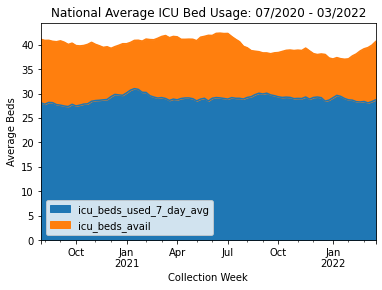

In [43]:
## all hospitals grouped by week, take sum of total beds and used beds
## display as area chart
icu_cols = ["icu_beds_used_7_day_avg","icu_beds_avail"]
icu_only = hospital_data.filter(icu_cols)
icu_only.index = hospital_data.collection_week
icu_grouped = icu_only.groupby(level=0).mean()
icu_grouped.plot.area()
plt.xlabel("Collection Week")
plt.ylabel("Average Beds")
plt.title("National Average ICU Bed Usage: 07/2020 - 03/2022")

In [5]:
## need to make sure I am only selecting hospitals that have reported every week
## get count and make sure it equals the total number of weeks in the filtered data

hosp_study_train = hospital_data[(hospital_data.collection_week >= "2021-04-01") & (hospital_data.collection_week <= "2021-08-01") &
                          (hospital_data.icu_beds_used_7_day_avg > 0)]
hosp_study_test = hospital_data[(hospital_data.collection_week >= "2021-08-02") & (hospital_data.collection_week <= "2021-08-28") &
                          (hospital_data.icu_beds_used_7_day_avg > 0)]
#weekly report count for each hospital, use this to filter only to hospitals that reported every week
weekly_report_count_train = hosp_study_train.groupby(["hospital_name"]).count().filter(["city"])
weekly_report_count_test = hosp_study_test.groupby(["hospital_name"]).count().filter(["city"])

final_hosp_names_train = weekly_report_count_train[weekly_report_count_train.city == len(hosp_study_train.collection_week.unique())].index
final_hosp_names_test = weekly_report_count_test[weekly_report_count_test.city == len(hosp_study_test.collection_week.unique())].index


hosp_study_train = hosp_study_train[hosp_study_train.hospital_name.isin(final_hosp_names_train)]
hosp_study_test = hosp_study_test[hosp_study_test.hospital_name.isin(final_hosp_names_test)]

hosp_study_train = hosp_study_train.reset_index()
hosp_uniq = hosp_study_train.hospital_name.unique()


In [6]:
hosp_study_train.hospital_name.unique()

<StringArray>
[                      'ABBOTT NORTHWESTERN HOSPITAL',
                         'ABINGTON MEMORIAL HOSPITAL',
                            'ABRAZO ARROWHEAD CAMPUS',
                              'ABRAZO CENTRAL CAMPUS',
                                 'ABRAZO WEST CAMPUS',
            'ACUITY SPECIALTY HOSPITAL OF MORGANTOWN',
                      'ADENA REGIONAL MEDICAL CENTER',
                           'ADVENTHEALTH CARROLLWOOD',
                         'ADVENTHEALTH CENTRAL TEXAS',
                             'ADVENTHEALTH DADE CITY',
 ...
                     'WILKES REGIONAL MEDICAL CENTER',
                'WILLIS KNIGHTON MEDICAL CENTER, INC',
                          'WINCHESTER MEDICAL CENTER',
                              'WINTER HAVEN HOSPITAL',
                    'WOODLAND HEIGHTS MEDICAL CENTER',
                             'YAKIMA VALLEY MEMORIAL',
                            'YALE-NEW HAVEN HOSPITAL',
                    'YAVAPAI REGIONAL MEDICAL 

In [36]:
list(range(19))
len(list(range(18)))

18

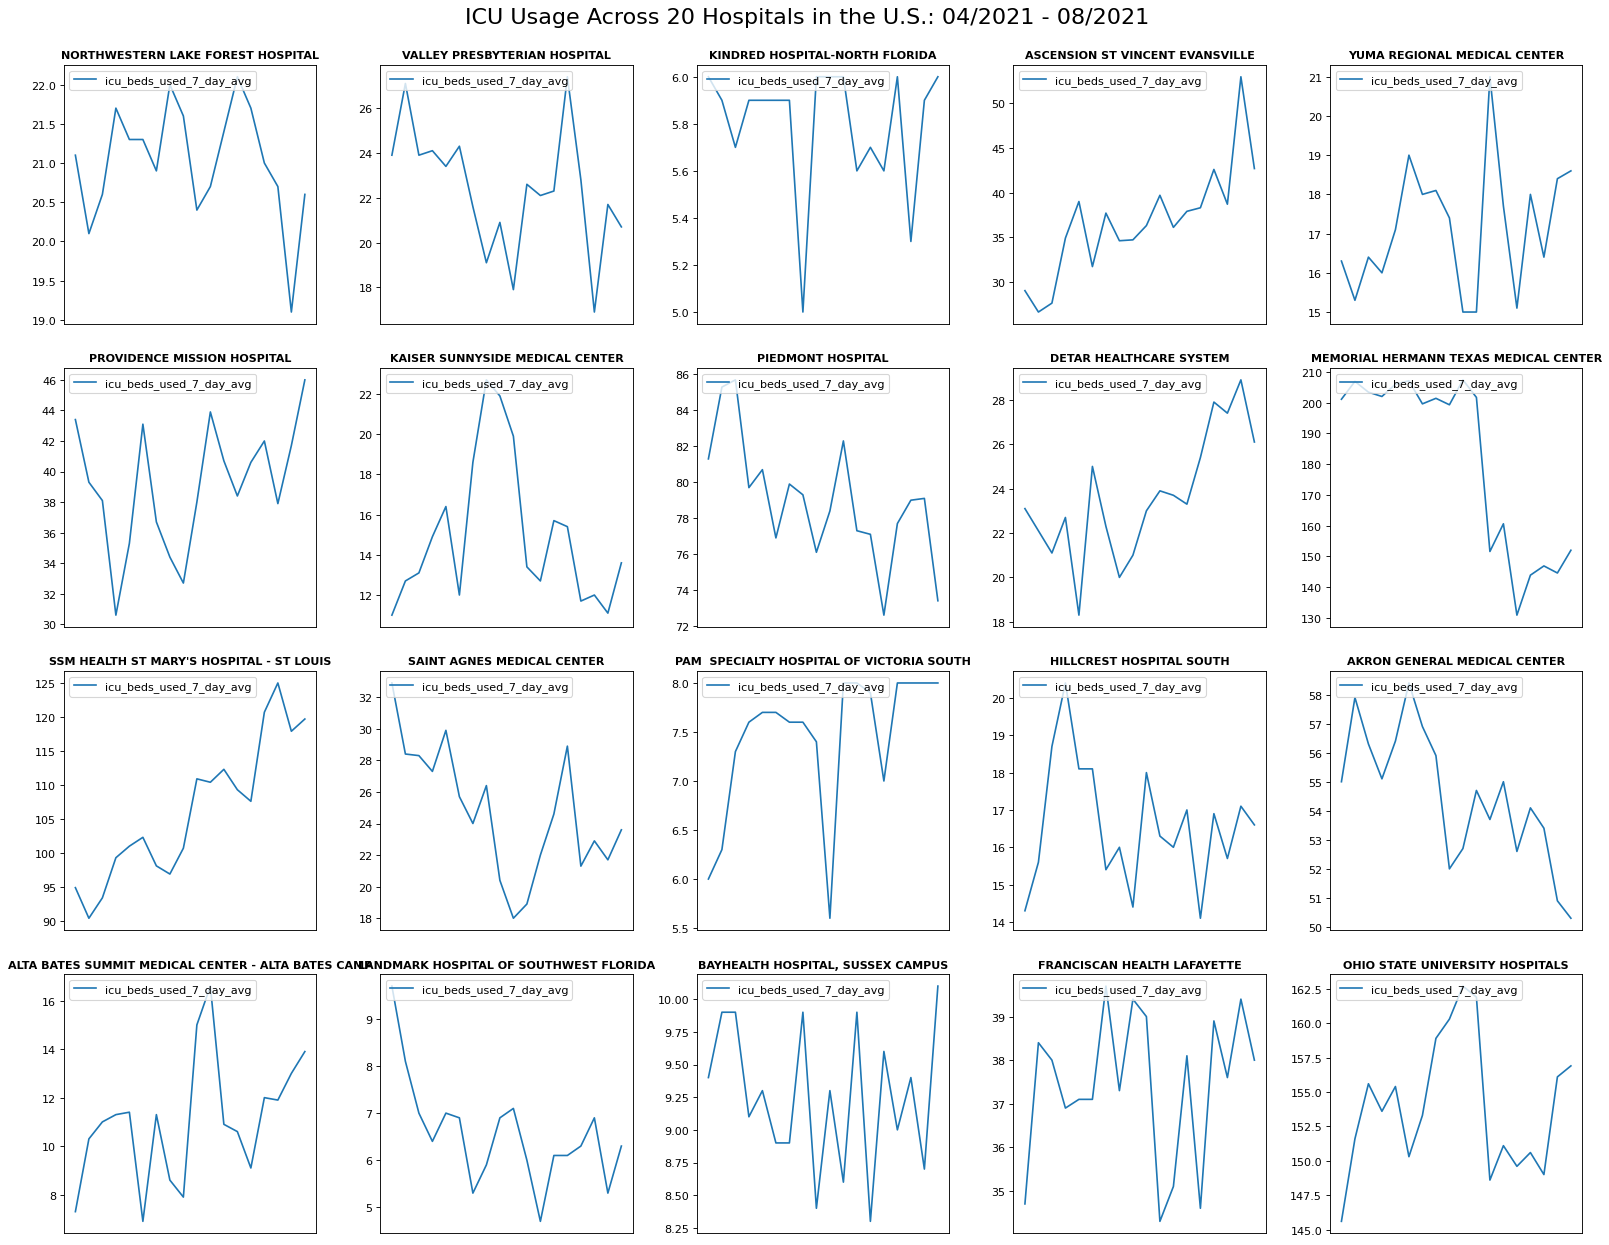

In [39]:
np.random.seed(101)
# select 20 random counties
hosp_name_train_study = hosp_uniq[list(sts.randint.rvs(low=0,high=hosp_uniq.shape[0]-1,size=20))]

index = 1
fig = figure(figsize=(20, 16), dpi=80)
cols_to_plot = ["icu_beds_used_7_day_avg"]

for c in hosp_name_train_study:

    df = hosp_study_train[hosp_study_train.hospital_name == c]
    ax = fig.add_subplot(4,5,index)
    index += 1

    fig.suptitle("ICU Usage Across 20 Hospitals in the U.S.: 04/2021 - 08/2021",fontsize=20)
    df[df.columns.intersection(cols_to_plot)].plot(ax=ax)
    plt.xticks([])
    plt.title(c,fontsize="medium",fontweight="bold")
    plt.legend(loc="upper left")
    
    #plt.xlabel("")

plt.tight_layout(pad=2.2)

In [8]:
## initial guess needs to be absolute rounded value of differences for each week

tt = hosp_study_train[hosp_study_train.hospital_name == final_hosp_names_train[2]].filter(cols_to_plot).icu_beds_used_7_day_avg.tolist()
tt = [round(x) for x in tt]



In [9]:
def weekly_diffs(arr):
    ## function to calculate weekly differences in bed counts
    ## returns estimates for lambda based on average of positive/negative weekly differences
    
    diffs = [0]
    for i in range(1,len(arr),1):
        diffs.append(arr[i] - arr[i-1])

    lambda_est = [x for x in diffs if x >= 0]
    mu_est = [abs(x) for x in diffs if x < 0]
    
    return np.mean(lambda_est),np.mean(mu_est)

In [10]:
prms = bd.estimate(t_data=range(len(tt)),p_data=tt,p0=[1,3],p_bounds=[[.1,4],[.1,4]],model="M/M/1",framework="lse").p
prms

[2.256231309245662, 1.7856430677291932]

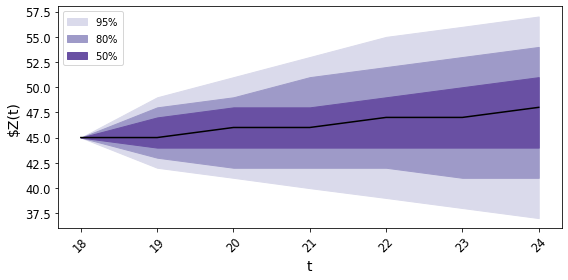

In [11]:
test = bd.forecast(model="M/M/1",z0=tt[17],times=list(range(18,25,1)),param=prms,interval="prediction",p_bounds=[[.1,100],[.1,100]])


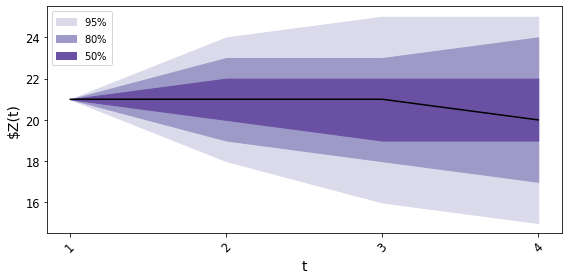

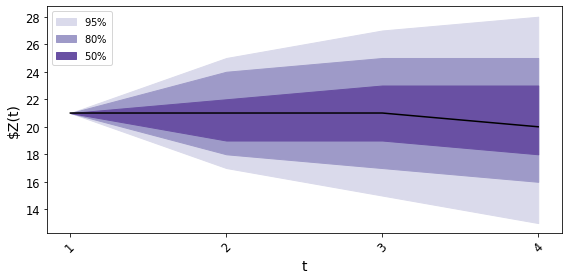

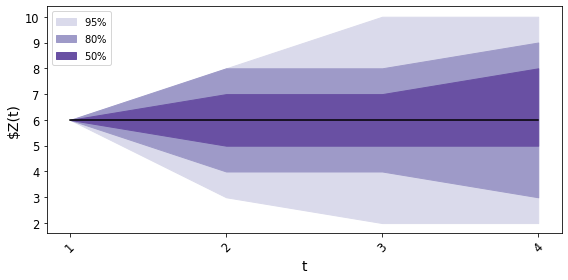

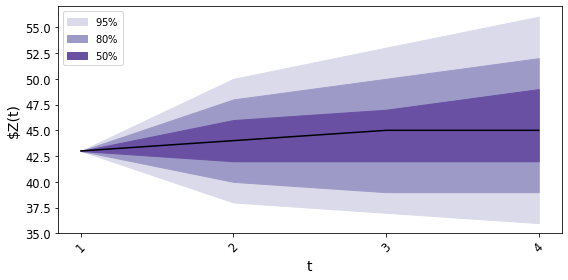

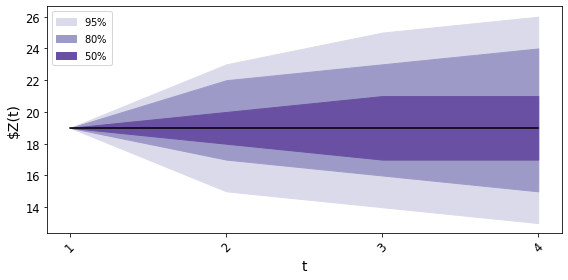

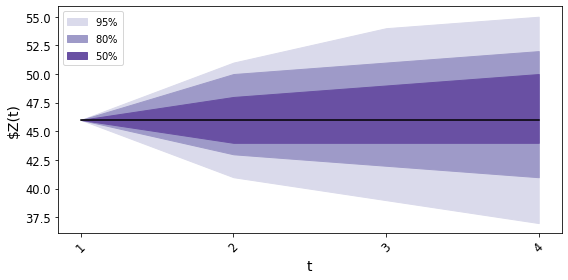

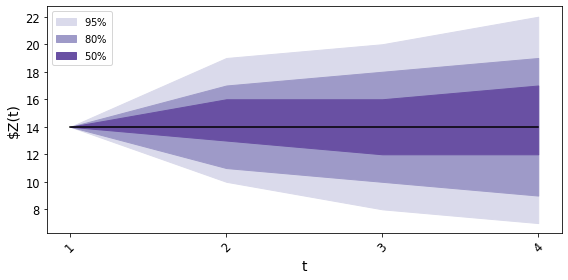

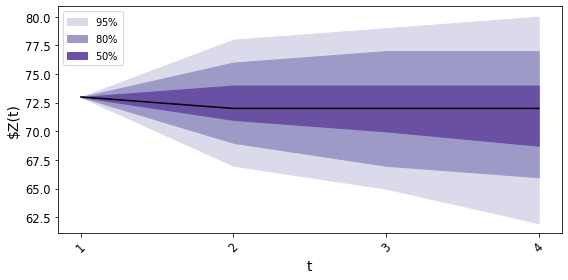

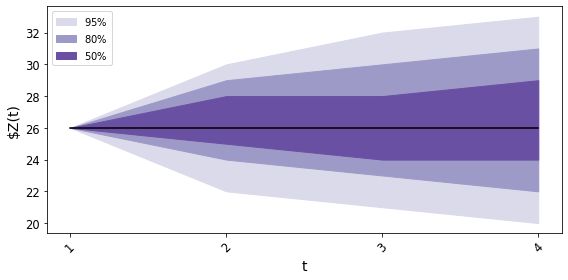

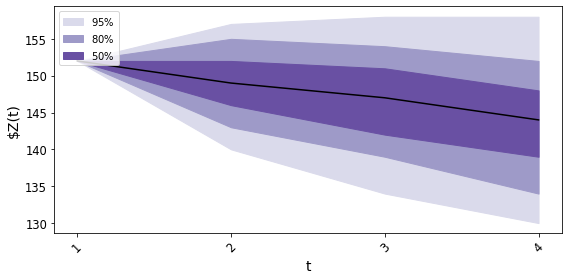

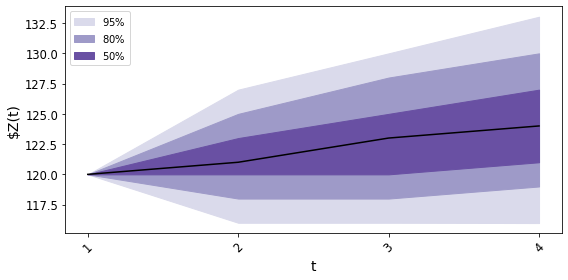

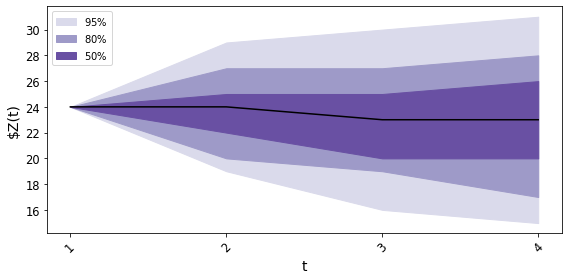

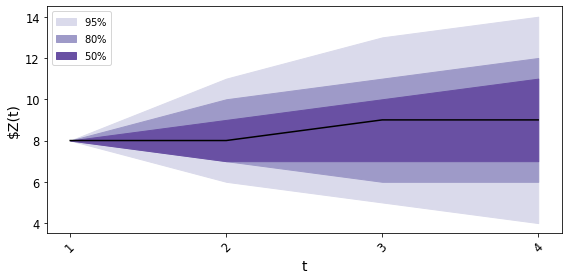

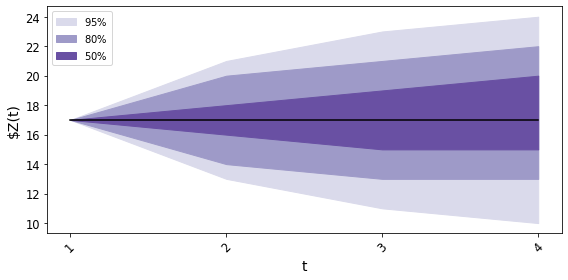

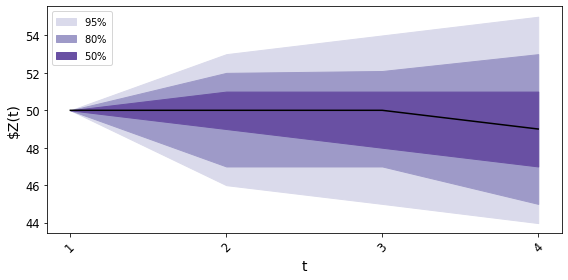

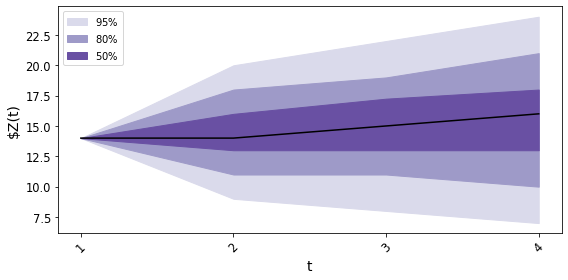

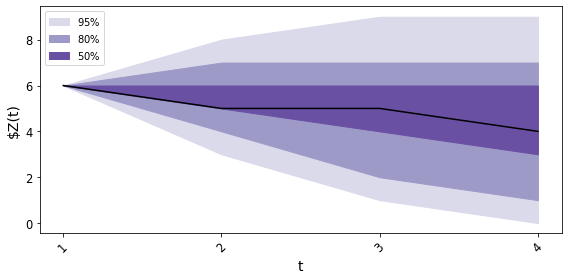

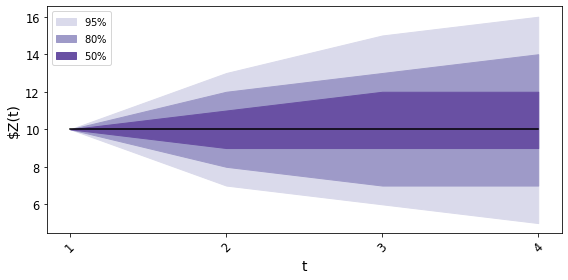

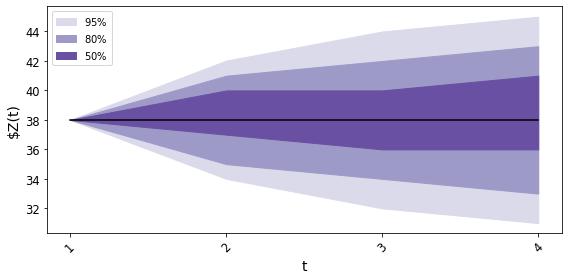

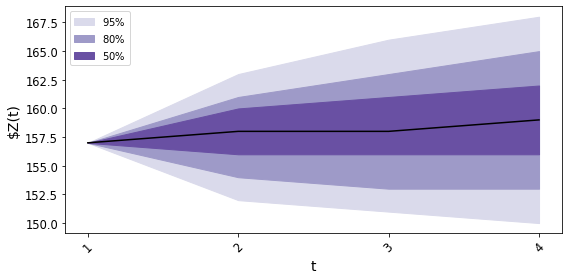

In [12]:
#forecast is just an average of discrete simulations based on parameter estimation and their uncertainty

# use above 2 boxes for creating estimates and models for 20 hospitals in picture that is plotted
## are any of them positive recurrent? 
## steady-state probabilities?
## draw 

# for each hospital, /get last 18 weeks of data, round it
# estimate the parameters with just 10,10.5 for now (could be more sophisticated starting point)
# create forecast, this will return the forecasted numbers as array and plot each 
    ### need to add each of these plots to the subplot

filter_cols = ["total_icu_beds_7_day_avg","icu_beds_used_7_day_avg"]
mdl = "M/M/1"
icu_dict = {}

for h in hosp_name_train_study:
    
    hosp_icu = hosp_study_train[hosp_study_train.hospital_name == h].filter(filter_cols).icu_beds_used_7_day_avg.tolist()
    hosp_both = hosp_study_train[hosp_study_train.hospital_name == h].filter(filter_cols)
    
    icu_data = [round(x) for x in hosp_icu]
    prm_ests = weekly_diffs(icu_data)
    prms = bd.estimate(t_data=range(len(icu_data)),p_data=icu_data,p0=prm_ests,p_bounds=[[.1,20],[.1,20]],model=mdl,framework="lse").p
    fcst = bd.forecast(model=mdl,z0=icu_data[17],times=list(range(1,5,1)),param=prms,interval="prediction",p_bounds=[[.1,100],[.1,100]])
    
    icu_dict[h] = [prms,fcst]


In [13]:
## are any of the above positive recurrent?

## if so, using the equation in text to calculate
hosp_study_test.icu_beds_used_7_day_avg

172471      4.4
169327     52.1
168119     14.1
173432     73.6
174500     51.0
          ...  
156698     27.3
155359    240.6
146881     28.4
145882     21.1
163328     39.1
Name: icu_beds_used_7_day_avg, Length: 9288, dtype: float64

# maybe use below to recreate the forecasts w/uncertainty

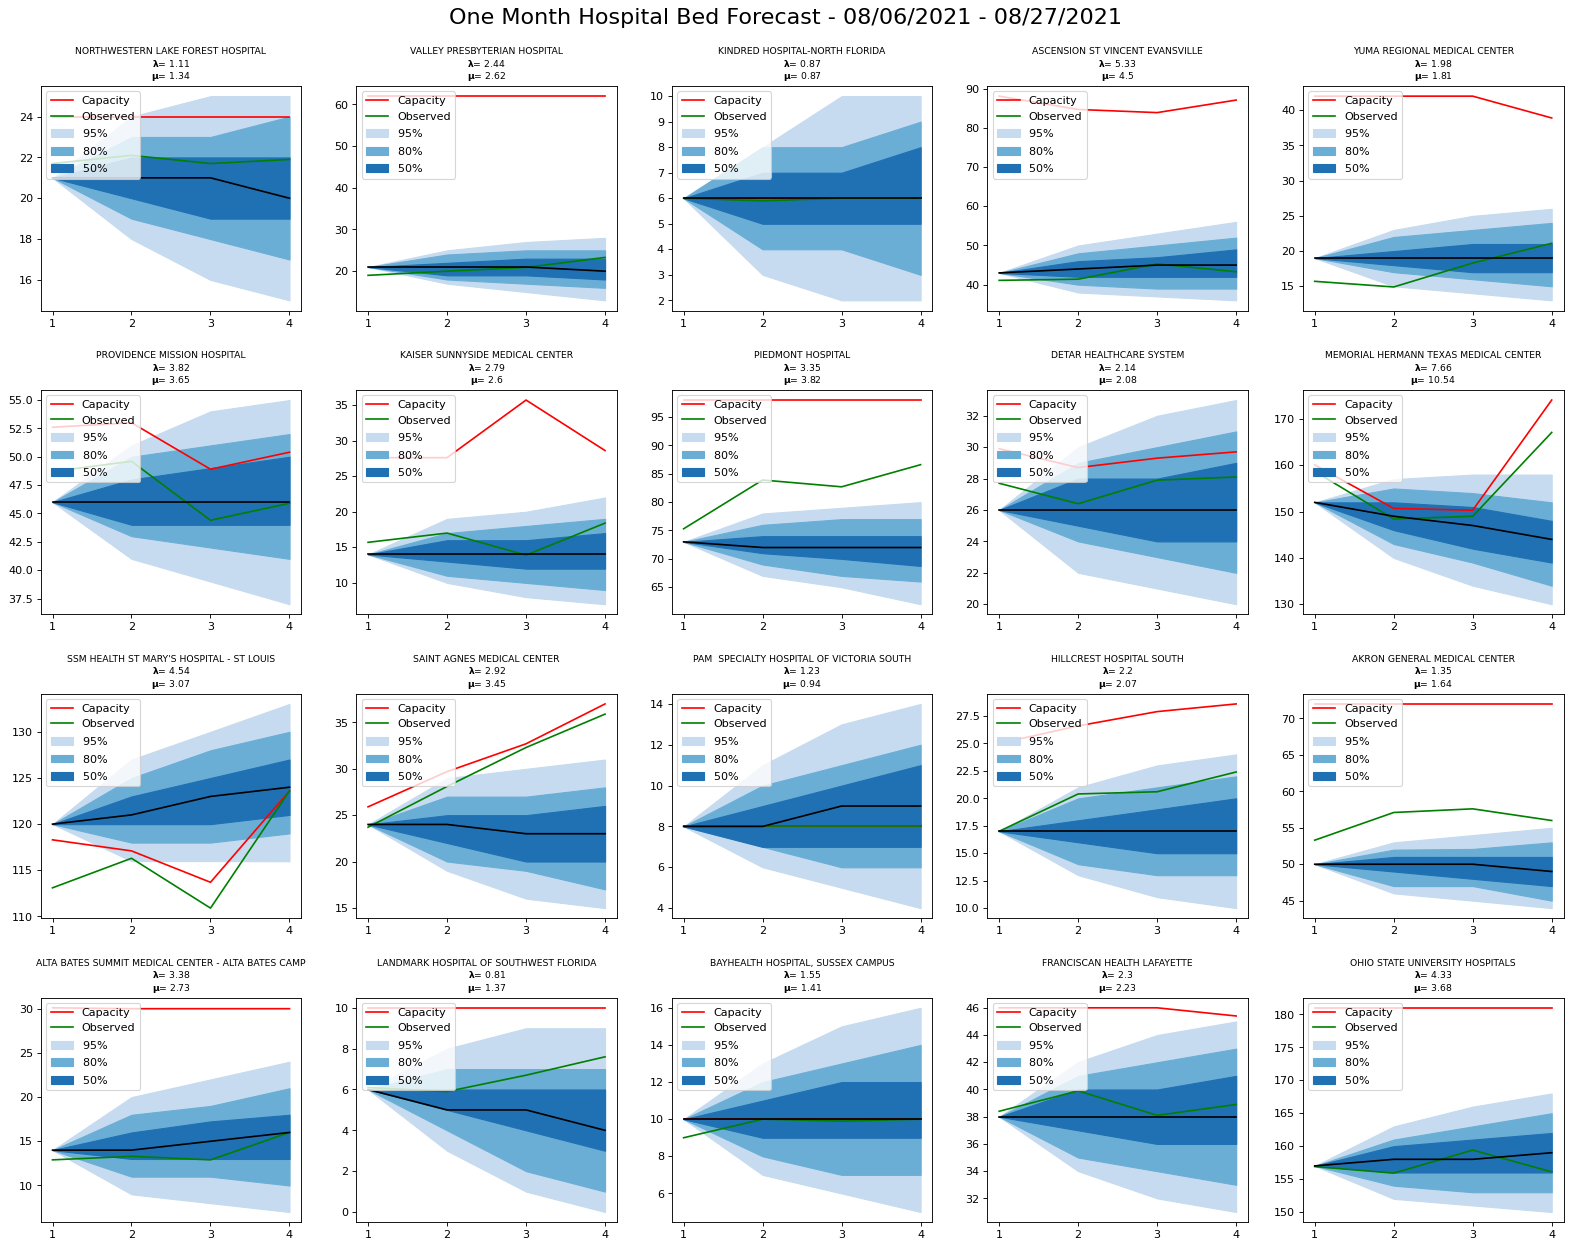

In [42]:
index = 1
fig = figure(figsize=(20, 16), dpi=80)
from matplotlib import cm



# bd.forecast() returns an array of all simulation results
# 50th percentile is median (center line)
# can calculate the 2.5th,10th,25th,75th,90th,97.5th as well for the shaded plotting fill_between it looks like based on source code
    
# create forecast plots for next 4 weeks post Aug 1 2021. 
# for each hospital get the observed data too from the test df
# add lambda and my labels to each graph as well

colormap = cm.Blues
labels=('$95\%$', '$80\%$', '$50\%$')

perc_50 = {}
for k in icu_dict:
    
    
    rded_prms = [round(x,2) for x in icu_dict[k][0]]
    
    sim_vals = icu_dict[k][1]
    
    tot_beds = hosp_study_test[hosp_study_test.hospital_name == k].total_icu_beds_7_day_avg
    test_beds = hosp_study_test[hosp_study_test.hospital_name == k].icu_beds_used_7_day_avg
    
    pcts = np.percentile(sim_vals,[2.5,10,25,50,75,90,97.5],axis=0)
    
    perc_50[k] = [rded_prms,pcts[3],test_beds] # store 50% and observed data for RMSE
    fig.suptitle("One Month Hospital Bed Forecast - 08/06/2021 - 08/27/2021",fontsize=20)    
    
    ax = fig.add_subplot(4,5,index)
    index += 1
    
    #plot capacity
    cap_line = lines.Line2D(range(1,5,1),pd.Series(tot_beds).reset_index().total_icu_beds_7_day_avg,color="red",label="Capacity")
    obs_line = lines.Line2D(range(1,5,1),pd.Series(test_beds).reset_index().icu_beds_used_7_day_avg,color="green",label="Observed")
    #add median
    line = lines.Line2D(range(1,5,1),pcts[3],color='k')
    ax.add_line(cap_line)
    ax.add_line(obs_line)
    ax.add_line(line)
    
    ## 0, 6 is 95%, 1,5 is 80%, 2,4 is 50%, 3 is median
    
    #add 95%
    ax.fill_between(range(1,5,1),pcts[0],pcts[6],color=colormap(.25),label=labels[0])
    #add 80%
    ax.fill_between(range(1,5,1),pcts[1],pcts[5],color=colormap(.5),label=labels[1])
    # add 50%
    ax.fill_between(range(1,5,1),pcts[2],pcts[4],color=colormap(.75),label=labels[2])
    
    ## add the parameters for each hospital
    
    lmbda_text = r"$\mathbf{\lambda}$= "+str(rded_prms[0])
    mu_text = r"$\mathbf{\mu}$= "+str(rded_prms[1])
    
    plt.xticks([1,2,3,4])
    plt.title(k+"\n"+lmbda_text+"\n"+mu_text,fontsize="small")
    
    
    
    ax.legend(loc="upper left")   
    
plt.tight_layout(pad=2)    


In [15]:
## calculate RMSE for each hospital model

# for each hospital

# calculate 50th percentile and store

def calc_rmse(hosp):
    
    return(np.sqrt(sum((perc_50[hosp][1]-perc_50[hosp][2])**2)/len(perc_50[hosp][1])))

rmse_dict = {}
for k in perc_50:
    
    #perc_50[k].append(calc_rmse(k))
    rmse_dict[k] = [perc_50[k][0][0],perc_50[k][0][1],calc_rmse(k)]
# extract 4 weeks of data post aug 1 2021
   # can use this for denom in RMSE%
# RMSE for each hospital in table along with Z(t+1) as a column
# maybe RMSE% = RMSE/sum(observed beds) / n


Text(0, 0.5, 'Bed Count')

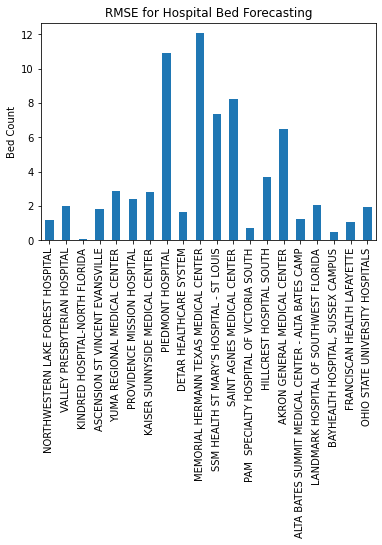

In [23]:
hosp_rmse = pd.DataFrame(rmse_dict).T
hosp_rmse.set_axis([r"$\mathbf{\lambda}$",r"$\mathbf{\mu}$","RMSE"],axis=1,inplace=True)

hosp_rmse.RMSE.plot(kind='bar',title="RMSE for Hospital Bed Forecasting")
plt.ylabel("Bed Count")

In [20]:
hosp_rmse

,$\mathbf{\lambda}$,$\mathbf{\mu}$,RMSE
NORTHWESTERN LAKE FOREST HOSPITAL,1.11,1.34,1.204159
VALLEY PRESBYTERIAN HOSPITAL,2.44,2.62,1.993740
KINDRED HOSPITAL-NORTH FLORIDA,0.87,0.87,0.050000
ASCENSION ST VINCENT EVANSVILLE,5.33,4.50,1.826883
YUMA REGIONAL MEDICAL CENTER,1.98,1.81,2.854820
PROVIDENCE MISSION HOSPITAL,3.82,3.65,2.388514
KAISER SUNNYSIDE MEDICAL CENTER,2.79,2.60,2.795532
PIEDMONT HOSPITAL,3.35,3.82,10.892084
DETAR HEALTHCARE SYSTEM,2.14,2.08,1.663580
MEMORIAL HERMANN TEXAS MEDICAL CENTER,7.66,10.54,12.071247
